ResNet18

BasicBlock
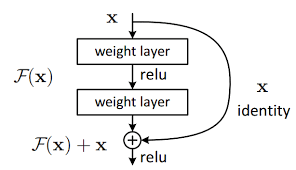

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Residual Block 정의 (기본 블록)
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        # 첫 번째 Conv 레이어
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # 배치 정규화
        self.relu = nn.ReLU(inplace=True)

        # 두 번째 Conv 레이어
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)  # 배치 정규화

        self.downsample = downsample  # 다운샘플링(차원 맞추기)을 위한 레이어
        self.stride = stride

    def forward(self, x):
        identity = x  # 잔차 연결을 위한 identity(원본 입력)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # 다운샘플링이 필요할 경우 identity의 차원 조정
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity  # 잔차 연결 (Residual Connection)
        out = self.relu(out)  # ReLU 활성화 함수

        return out

make_layer

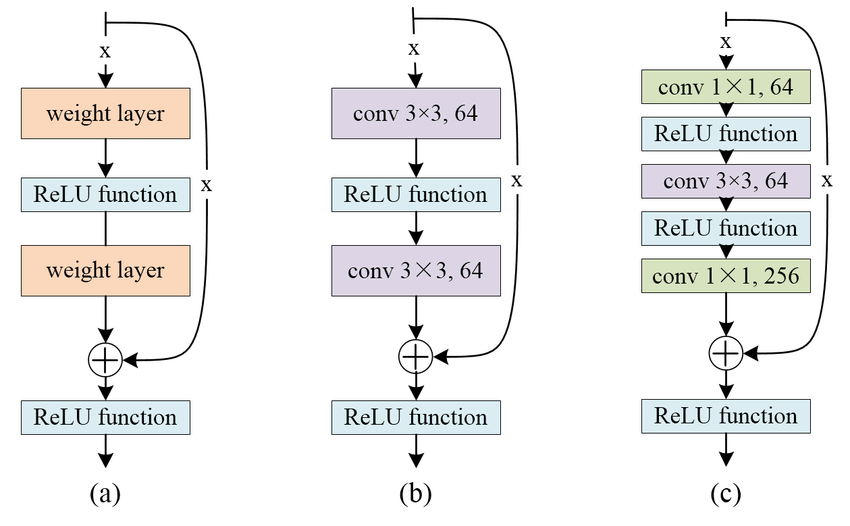

In [ ]:
# 레이어를 동적으로 생성하는 함수
def make_layer(block, in_channels, out_channels, num_blocks, stride=1):
    downsample = None

    # stride가 1이 아니거나, 입력 채널과 출력 채널이 다를 경우, 다운샘플링 필요
    if stride != 1 or in_channels != out_channels:
        downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    layers = []
    # 첫 번째 블록 (다운샘플링 적용)
    layers.append(block(in_channels, out_channels, stride, downsample))

    # 나머지 블록들 (다운샘플링 없는 블록들)
    for _ in range(1, num_blocks):
        layers.append(block(out_channels, out_channels))

    return nn.Sequential(*layers)

ResNet

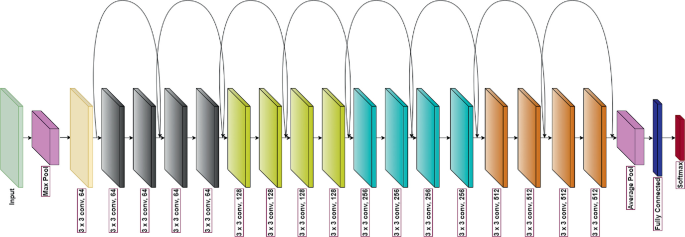

In [ ]:
# ResNet18 정의
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, input_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64  # 기본 채널 수는 64

        # 첫 번째 Conv 레이어
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # make_layer 함수를 사용하여 각 레이어를 정의
        self.layer1 = make_layer(block, 64, 64, layers[0], stride=1)
        self.layer2 = make_layer(block, 64, 128, layers[1], stride=2)
        self.layer3 = make_layer(block, 128, 256, layers[2], stride=2)
        self.layer4 = make_layer(block, 256, 512, layers[3], stride=2)

        # Global Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layer
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

결과

In [ ]:
# ResNet18 모델 구성 (BasicBlock 사용)
def ResNet18Model():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# 모델 생성
resnet18 = ResNet18Model()

# 모델 확인
print(resnet18)